In [1]:
import numpy as np
import pandas as pd
import splat
import popsims
from astropy.coordinates import SkyCoord, Galactic
from popsims.galaxy import Pointing, volume_calc, create_pop
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
#sns.set_style("darkgrid", {"axes.facecolor": ".95"})

#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')

from  matplotlib.colors import Normalize
import astropy.units as u
import popsims
import matplotlib
from tqdm import tqdm
from tqdm import tqdm
import matplotlib as mpl 
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] =20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['figure.titlesize'] = 20

splat.initializeStandards(all=True)

%matplotlib inline

/Users/caganze/testsplat/splat


Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
import numpy
import shapey
import splat
import popsims

In [3]:
fig_folder='/users/caganze/research/popsims/figures/'
data_folder='/users/caganze/research/popsims/data/'

In [4]:
AREA=4.4*(u.arcmin**2)*124

In [5]:
H=350
FOV={'jswt': AREA}
#make magnitude cuts
grism_cuts={'JSWT':{ 'NIRISS_F115W':[1, 27.],\
                    'NIRISS_F150W':[1, 27.] }}

#the goods north field
#OINTS={'jswt':SkyCoord(ra="12:36:55", dec="62:14:15", unit=(u.hourangle, u.deg))}
POINTS={'jswt':SkyCoord(l=np.random.uniform(-180, 180, 10 )*u.degree,\
               b=np.random.uniform(-90, 90, 10)*u.degree, frame='galactic')}

In [6]:
#local luminosity function
#LF=pd.read_pickle(popsims.DATA_FOLDER+'/lf_scales.pkl')

In [7]:
def scale_to_lf(data):
    scale=data.scale.iloc[0]
    return scale
        

def make_cuts(df,  cut_dict, survey='JSWT'):
    dcts=grism_cuts[survey]
    return df[np.logical_and.reduce([df[k]< dcts[k][1] for k in dcts.keys()])]

def get_average_distance_limits(p, cut_dict, survey='JSWT'):
    p.mag_limits=grism_cuts[survey.upper()]
    return dict(pd.DataFrame(p.distance_limits).applymap(lambda x: x[1]).median(axis=1))

In [8]:
def sample_pointings(scaleH, scaleL, NSAMPLE, volume_kind='exp'):
    ds=[]
    for c in tqdm(POINTS['jswt']):
        p= Pointing(coord=c,density= volume_kind)
        ds.append(p.draw_distances(1, 50000, \
                    scaleH, scaleL, nsample=1e4))
    ds=np.array(ds).flatten()
    return  np.random.choice(ds, int(NSAMPLE), replace=True)

def compute_normalized_volumes(scaleH, scaleL, volume_kind='exp'):
    vs=dict(zip(range(17, 42),np.zeros(len(range(17, 42)))))
    for c in tqdm(POINTS['jswt']):
        p=Pointing(coord=c,density= volume_kind)
        for s in range(17, 42):
            vs[s]+=volume_calc(p.coord.galactic.l.radian,\
                                   p.coord.galactic.b.radian,
                                    0, DIST_LIMITS[s],scaleH, scaleL, \
                                   kind= volume_kind)
    
    return  vs

In [9]:
p=Pointing(coord=POINTS['jswt'])
p.mag_limits=grism_cuts['JSWT']
DIST_LIMITS=get_average_distance_limits(p, grism_cuts['JSWT'], survey='JSWT')

In [10]:
#DIST_LIMITS[17]

In [11]:
VOLUMES={'thin_disk': compute_normalized_volumes(350,2600, volume_kind='exp'),
         'thick_disk':compute_normalized_volumes(900, 3600, volume_kind='exp'),
         'halo': compute_normalized_volumes(900, 3600, volume_kind='spheroid'),
}

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 260.97it/s]


In [12]:
VOLUMES

{'thin_disk': {17: 51752850038.646996,
  18: 51752849125.71977,
  19: 51752812729.923225,
  20: 51752267934.91937,
  21: 51747762135.666626,
  22: 51724459040.86025,
  23: 51642363531.5327,
  24: 51431994256.561356,
  25: 51017845002.382805,
  26: 50360094442.25766,
  27: 49477234714.10046,
  28: 48426331050.31256,
  29: 47253590061.60402,
  30: 45941182073.51962,
  31: 44361497158.23492,
  32: 42231114155.243126,
  33: 39058683495.93054,
  34: 34145082386.68013,
  35: 26884833333.766888,
  36: 17715770309.552208,
  37: 8961415881.565802,
  38: 3220837638.3052096,
  39: 725152876.2693536,
  40: 76262352.97866057,
  41: 2810260.4551499602},
 'thick_disk': {17: 316183915172.12756,
  18: 316131119469.8509,
  19: 315831317772.5608,
  20: 314730327763.81836,
  21: 311824538862.45306,
  22: 305919275438.029,
  23: 296216748913.1238,
  24: 282830173880.4568,
  25: 266813481332.14838,
  26: 249701789394.11826,
  27: 232905951891.81137,
  28: 217282615202.4595,
  29: 202965052034.33667,
  30: 1

In [13]:
def get_numbers(coord, fov, cuts, **kwargs):
    NCOUNTS={}
    spgrid=kwargs.get('spgrid', [20, 30])
    scaleH=kwargs.get('h', 350)
    scaleL=kwargs.get('l', 2600)
    kind=kwargs.get('kind', 'exp')
    survey=kwargs.get('survey', 'survey')
    model=kwargs.get('model', 'burrows1997')
    mag_keys=kwargs.get('mag_keys', [])
    
    volume_kind=kind
    if kind!='exp':
        volume_kind='spheroid'

    galactic_dists=sample_pointings(scaleH, scaleL, 1e6, volume_kind= volume_kind)
    
    dff=create_pop(bfraction=0.2,\
                         model= model,\
                           l=list(POINTS['jswt'].galactic.l.radian),
                           b=list(POINTS['jswt'].galactic.b.radian),
                           absmag_keys=mag_keys, \
                           nsample=int(1e6),
                           distances=galactic_dists,
                  poptype='dwarfs')
    
    scale=np.nanmedian(dff.scale)
    df_cut= make_cuts(dff,cuts, survey=survey)
    nxbr_counts=[]
    vols=[]
    
    #compute volumes
    p= Pointing(coord=POINTS['jswt'][0])
    dct= get_average_distance_limits(p, cuts, survey=survey)
    for spt in tqdm(spgrid):
        sptvol=volume_calc(p.coord.galactic.l.radian,\
                                   p.coord.galactic.b.radian,
                                   1., dct[spt],scaleH, scaleL, kind= volume_kind)*(fov.to(u.radian**2)).value
        df_select= df_cut[np.logical_and(df_cut.spt>=spt, df_cut.spt<spt+0.99)]


        nbrs=len(df_select)
        cnbrs=nbrs*sptvol*scale
        vols.append(sptvol)
        nxbr_counts.append(cnbrs)
    NCOUNTS['counts']=np.array(nxbr_counts)
    NCOUNTS['volumes']=np.array(vols)
    NCOUNTS['data']=df_cut
    return NCOUNTS
        



In [14]:
def get_numbers_by_model(model='burrows1997'):
    thin_number_200=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', h=200, model=model)
    
    thin_number_400=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', h=400, model=model)
    
    thick_number=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', h=900, l=3600, model=model)
    
    halo_number=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', kind='halo', model=model)
    
    return {'thin_200': thin_number_200, 'thin_400': thin_number_400, \
            'thick': thick_number, 'halo': halo_number}

In [15]:
#b97=get_numbers_by_model(model='burrows1997')
b01=get_numbers_by_model(model='burrows2001')
b03=get_numbers_by_model(model='baraffe2003')

100%|██████████████████████████████████████████| 25/25 [00:00<00:00, 986.93it/s]


In [16]:
import collections
isinstance(list(POINTS['jswt'].galactic.l.radian), collections.Sequence)

True

In [17]:
POINTS['jswt'].galactic.l.radian

array([4.5796414 , 2.50995244, 0.83348272, 3.20296055, 3.28485134,
       1.3819183 , 1.07483654, 1.92310306, 4.44527679, 5.05732627])

In [18]:
DIST_LIMITS

{10: 394788.3997572347,
 11: 231956.39832653297,
 12: 150651.92179739458,
 13: 105711.00742120016,
 14: 78682.86969866806,
 15: 61218.9840687938,
 16: 49216.87324844973,
 17: 40523.70521976924,
 18: 33950.2627450928,
 19: 28812.484600789612,
 20: 24702.737635531863,
 21: 21368.708046814594,
 22: 18646.427956164964,
 23: 16422.375401040226,
 24: 14611.94430059495,
 25: 13147.262140524468,
 26: 11970.17609247347,
 27: 11027.82976429452,
 28: 10269.279815687496,
 29: 9642.362757069517,
 30: 9090.71970124314,
 31: 8551.6999471248,
 32: 7956.896847006794,
 33: 7238.129121943718,
 34: 6341.88194922569,
 35: 5252.692629694977,
 36: 4018.65495432413,
 37: 2761.3463109893373,
 38: 1647.8763147940658,
 39: 821.127100198461,
 40: 326.67718290863576,
 41: 98.80716341776477,
 42: 21.60833560751091}

In [19]:
def tick_function(locs, distlimits):
   
    return ["{:.1f} ".format(distlimits[x]/1000) for x in locs]

In [20]:
#np.nansum(halo_number['counts']*(1/400)), np.nansum(thick_number['counts']*(0.12))
conversion_area=1/AREA

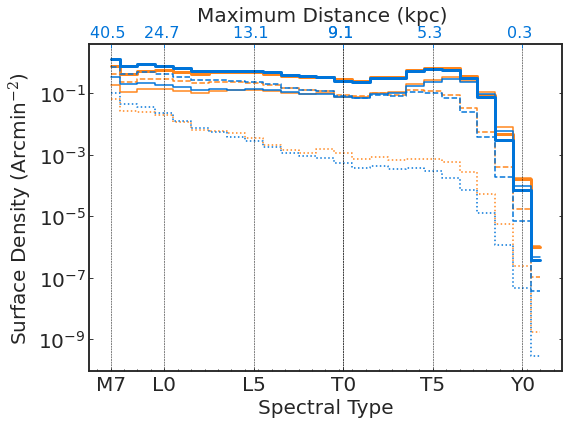

In [39]:
fig, ax=plt.subplots(figsize=(8, 6))
#plt.step(np.arange(17, 42), b97['halo']['counts']*(1/400)*conversion_area,\
#         where='mid',  linestyle='dotted', color='#0074D9', label='B97 Halo')
#plt.step(np.arange(17, 42), b97['thin']['counts']*conversion_area, \
#          where='mid',  linestyle='-', color='#0074D9', label='B97 Thin Disk')
#plt.step(np.arange(17, 42), b97['thick']['counts']*(0.12)*conversion_area, \
#          where='mid',  linestyle='--', color='#0074D9',label='B97 Thick Disk')


plt.step(np.arange(17, 42), b01['thin_200']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#FF851B',  label='B01 Thin Disk, H= 200 pc')

plt.step(np.arange(17, 42), b01['thin_400']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#FF851B',  linewidth=3, label='B01 Thin Disk, H= 400 pc')

plt.step(np.arange(17, 42), b01['thick']['counts']*(0.12)*conversion_area, \
        where='mid', linestyle='--', color='#FF851B',   label='B01 Thick Disk')
plt.step(np.arange(17, 42), b01['halo']['counts']*(1/400)*conversion_area,\
         where='mid',  linestyle='dotted', color='#FF851B',  label='B01 Halo')


plt.step(np.arange(17, 42), b03['thin_200']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#0074D9',  label='B03 Thin Disk, H=200 pc')

plt.step(np.arange(17, 42), b03['thin_400']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#0074D9',  linewidth=3, label='B03 Thin Disk, H= 400 pc')

plt.step(np.arange(17, 42), b03['thick']['counts']*(0.12)*conversion_area, \
         where='mid', linestyle='--', color='#0074D9', label='B03 Thick Disk')
plt.step(np.arange(17, 42), b03['halo']['counts']*(1/400)*conversion_area,\
         where='mid', linestyle='dotted', color='#0074D9', label='B03 Halo')


ax.set(xlabel='Spectral Type', \
       ylabel=r'Surface Density (Arcmin$^{-2}$)', xticks=[17, 20, 25, 30, 35, 40],
      xticklabels=['M7', 'L0', 'L5', 'T0', 'T5','Y0'], yscale='log')

ax.grid(False, which='both', axis='x')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.array([17, 20, 25, 30, 30, 35, 40])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations, DIST_LIMITS ), fontsize=16)
ax2.tick_params(colors='#0074D9', which='both') 
ax2.set_xlabel('Maximum Distance (kpc) ')
ax2.grid()
#ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize=14)
plt.tight_layout()
#ax.grid( axis='y',  which='major')
ax.minorticks_on()
plt.savefig(fig_folder+'/jswt_counts_nolegend.pdf', dpi=600)

In [22]:
b03['thin_400']['counts']/b03['thin_200']['counts']

array([4.0488442 , 3.98431362, 4.05429983, 4.02123181, 4.01314113,
       4.0333213 , 4.01849817, 3.89279507, 3.92507356, 3.87234396,
       3.67823972, 3.71592679, 3.55551384, 3.54238437, 3.34157264,
       3.32258958, 3.14933574, 2.92988897, 2.52073981, 1.93876563,
       1.335912  , 0.76857851, 0.52400896, 0.7531575 , 0.82953177])

In [23]:
spts= [x for x in np.arange(17, 42)]

In [24]:
#number report
num_rp=pd.DataFrame()
#
num_rp['max_distance']= [round(DIST_LIMITS[x]) for x in np.arange(17, 42)]
num_rp['thin_200_b01']= b01['thin_200']['counts']*conversion_area.value
num_rp['thin_200_b03']= b03['thin_200']['counts']*conversion_area.value
num_rp['thin_400_b01']= b01['thin_400']['counts']*conversion_area.value
num_rp['thin_400_b03']= b03['thin_400']['counts']*conversion_area.value

num_rp['thick_b01']=b01['thick']['counts']*(0.12)*conversion_area.value
num_rp['thick_b03']=b03['thick']['counts']*(0.12)*conversion_area.value

num_rp['halo_b01']=b01['halo']['counts']*(1/400)*conversion_area.value
num_rp['halo_b03']=b03['halo']['counts']*(1/400)*conversion_area.value
num_rp['average']= num_rp[['thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].mean(axis=1)
num_rp.index=spts

for c in num_rp.columns:
    num_rp.loc['total', c]= np.nansum(num_rp[c].loc[spts])
    num_rp.loc['average', c]= np.nanmedian(num_rp[c].loc[spts])

In [25]:
num_rp

,max_distance,thin_200_b01,thin_200_b03,thin_400_b01,thin_400_b03,thick_b01,thick_b03,halo_b01,halo_b03,average
17,40524.0,0.182025,3.206806e-01,7.436886e-01,1.298386e+00,4.058663e-01,7.174765e-01,6.169212e-02,1.030123e-01,4.791035e-01
18,33950.0,0.108136,1.910869e-01,4.260930e-01,7.613501e-01,2.339035e-01,4.119987e-01,2.703920e-02,4.335852e-02,2.753708e-01
19,28812.0,0.131278,2.199367e-01,5.358389e-01,8.916894e-01,2.959785e-01,4.836732e-01,2.364089e-02,3.623421e-02,3.272837e-01
20,24703.0,0.139087,1.875335e-01,5.429238e-01,7.541156e-01,2.966106e-01,4.078097e-01,1.877784e-02,2.169379e-02,2.960690e-01
21,21369.0,0.115857,1.577232e-01,4.790286e-01,6.329656e-01,2.523407e-01,3.349807e-01,1.141698e-02,1.273299e-02,2.496307e-01
22,18646.0,0.100867,1.270196e-01,4.170711e-01,5.123110e-01,2.127720e-01,2.631155e-01,6.419891e-03,7.308146e-03,2.058605e-01
23,16422.0,0.117905,1.319348e-01,4.715546e-01,5.301797e-01,2.320584e-01,2.574998e-01,5.942889e-03,5.217760e-03,2.190366e-01
24,14612.0,0.125342,1.297071e-01,4.918274e-01,5.049231e-01,2.279553e-01,2.398195e-01,4.866841e-03,3.719758e-03,2.160201e-01
25,13147.0,0.124685,1.328641e-01,4.851398e-01,5.215014e-01,2.160516e-01,2.267411e-01,3.343922e-03,2.668499e-03,2.141244e-01
26,11970.0,0.112666,1.229148e-01,4.253288e-01,4.759684e-01,1.793023e-01,1.906614e-01,2.039705e-03,1.799501e-03,1.888351e-01


In [26]:
#num_rp=num_rp.applymap(lambda x: np.round(x, 4))

In [27]:
num_rp.columns
#remember to change last column to total

Index(['max_distance', 'thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03',
       'average'],
      dtype='object')

In [28]:
num_rp[['max_distance', 'thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03', 'average']].to_latex('~/desktop/jswt_preds.tex', index=True)

In [29]:
num_rp.loc[17:19].sum()[[ 'thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].apply(lambda x: np.round(x, 5)).values

array([0.42144, 0.7317 , 1.70562, 2.95143, 0.93575, 1.61315, 0.11237,
       0.18261])

In [30]:
num_rp.loc[20:29].sum()[[ 'thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].apply(lambda x: np.round(x, 5)).values

array([1.12257, 1.27976, 4.35708, 4.99138, 2.0029 , 2.31223, 0.05694,
       0.05797])

In [31]:
num_rp.loc[30:39].sum()[[ 'thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].apply(lambda x: np.round(x, 5)).values

array([1.50293e+00, 1.37046e+00, 3.51133e+00, 3.17378e+00, 7.19530e-01,
       6.33430e-01, 5.75000e-03, 2.57000e-03])

In [32]:
num_rp.loc[40:41].sum()[[ 'thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].apply(lambda x: np.round(x, 5)).values

array([1.8e-04, 1.0e-04, 1.6e-04, 7.0e-05, 2.0e-05, 1.0e-05, 0.0e+00,
       0.0e+00])

In [33]:
num_rp.loc['total'][[ 'thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].apply(lambda x: np.round(x, 5)).values

array([ 3.04711,  3.38202,  9.57419, 11.11666,  3.65819,  4.55882,
        0.17507,  0.24314])

In [34]:
num_rp.loc['total']*(AREA/124)

max_distance    1.360489e+06
thin_200_b01    1.340730e+01
thin_200_b03    1.488089e+01
thin_400_b01    4.212643e+01
thin_400_b03    4.891331e+01
thick_b01       1.609605e+01
thick_b03       2.005880e+01
halo_b01        7.702952e-01
halo_b03        1.069815e+00
average         1.966536e+01
Name: total, dtype: float64

In [35]:
1.4*124*4.4

763.84

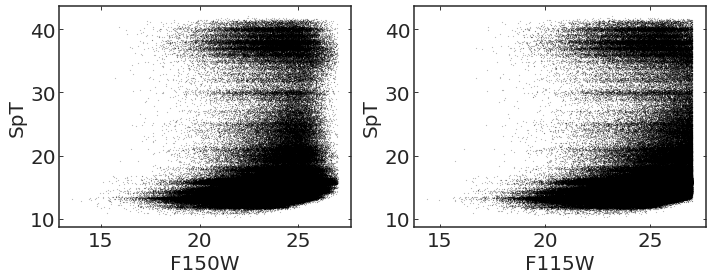

In [36]:
fig, (ax, ax1)=plt.subplots(ncols=2, figsize=(10, 4))
d=b01['halo']['data']
ax.scatter(d.NIRISS_F150W, d.spt, s=0.01, c='k')
ax1.scatter(d.NIRISS_F115W, d.spt, s=0.01, c='k')
plt.tight_layout()
ax.set(xlabel='F150W', ylabel='SpT')
ax1.set(xlabel='F115W', ylabel='SpT')
plt.tight_layout()

In [40]:
AREA

<Quantity 545.6 arcmin2>